In [27]:
import json
import math
import itertools
from collections import defaultdict
import numpy as np
from scipy.stats import spearmanr, shapiro
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

## Build graph

In [122]:
# Load data
artists_dict = json.load(open("data/artists_10k.json", "r"))
related_dict = json.load(open("data/related_10k.json", "r"))

In [123]:
# Build graph
G = nx.Graph()
for artist, related in related_dict.items():
    for next_artist in related:
        G.add_edge(artist, next_artist)

In [124]:
# Print basic graph properties
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
print("Connected components: ", nx.number_connected_components(G))
print("Average clustering coefficient: ", nx.average_clustering(G))

Number of nodes:  10005
Number of edges:  53284
Connected components:  1
Average clustering coefficient:  0.3649781995725766


In [131]:
# Number of clusters to analyze
num_clusters = 30

## Partitioning

In [10]:
# Partition graph
def partition(n, graph):
    comp = nx.community.girvan_newman(graph)
    limited = itertools.takewhile(lambda c: len(c) <= n, comp)
    return list(limited)[-1]

In [13]:
# Get graph partitions via Girvan-Newman
%time communities = partition(num_clusters, G)

CPU times: user 1h 41min 1s, sys: 10.2 s, total: 1h 41min 11s
Wall time: 1h 41min 20s


In [14]:
# Compute inverse document frequencies
idf = defaultdict(int)
for partition in communities:
    genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
    doc = "#".join(genres).replace(" ", "_").replace("#", " ")
    unique = set()
    for term in doc.split():
        if term not in unique:
            idf[term] += 1
            unique.add(term)
idf = {k:math.log(len(communities)/v) for k, v in idf.items()}

In [15]:
# Get most common genre in partition
def get_name(node_list):
    counts = defaultdict(int)
    for node in node_list:
        genres = artists_dict[node]["genres"]
        for genre in genres:
            counts[genre.replace(" ", "_")] += 1
    tf_idf = {k: v * idf[k] for k, v in counts.items()}
    return max(tf_idf, key=tf_idf.get)

In [38]:
# Get center of each partition
labels = {}
cluster_labels = []
for community in communities:
    sub = G.subgraph(list(community))
    sub_close = nx.closeness_centrality(sub)
    center = max(sub_close, key=sub_close.get)
    name = get_name(list(community)).replace("_", " ")
    labels[center] = name
    cluster_labels.append(name)
    print(artists_dict[center]["name"], name)

88GLAM trap
Christian French pop edm
Meek Mill southern hip hop
Meghan Trainor post-teen pop
Duckwrth underground hip hop
Kelly Rowland r&b
Canaan Smith contemporary country
Asian Doll trap queen
Steel Banglez uk hip hop
Panic! At The Disco pop punk
Rich Brian k-hop
Becky G latin
MAGIC! jawaiian
Josh X deep pop r&b
Lotto Boyzz uk hip hop


In [17]:
# Generate colors and labels for graph
colors = []
for node in G.nodes():
    for i in range(len(communities)):
        if node in communities[i]:
            colors.append(i)

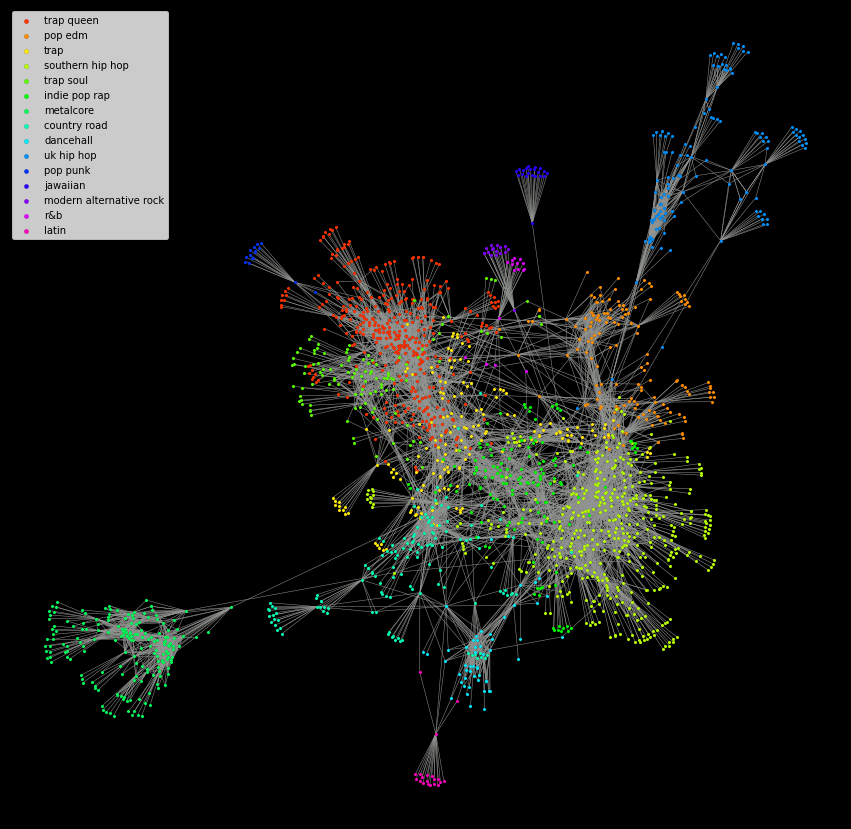

In [83]:
# Draw graph
fig, ax = plt.subplots(figsize=(15,15))
rainbow = plt.cm.get_cmap("gist_rainbow", len(communities)+1)
color_map = rainbow(range(len(communities)+1))
pos=nx.spring_layout(G)
for i, cluster in enumerate(communities):
    nx.draw_networkx_nodes(G, pos=pos, node_size=10, nodelist=cluster, ax=ax, node_color=[color_map[i+1]], 
                           linewidths=0.1, edgecolors='k', label=cluster_labels[i])
nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#929591", width=0.5)
ax.axis("off")
fig.set_facecolor('k')
lgnd = ax.legend(scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([20.0])
plt.show()

## Spectral Clustering

In [126]:
# Get clusters via spectral clustering
adj_mat = nx.to_numpy_matrix(G)
sc = SpectralClustering(num_clusters, affinity='precomputed', n_init=100, assign_labels='discretize')
%time sc.fit(adj_mat)

CPU times: user 1min 34s, sys: 12.7 s, total: 1min 47s
Wall time: 33.5 s


SpectralClustering(affinity='precomputed', assign_labels='discretize', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=20, n_components=None,
                   n_init=100, n_jobs=None, n_neighbors=10, random_state=None)

In [59]:
# Compute similarity between clusterings
print(metrics.adjusted_rand_score(colors, sc.labels_))
print(metrics.adjusted_mutual_info_score(colors, sc.labels_))

0.5773149926253419
0.7774680857891827


In [127]:
# Get clusters by ids
clusters = []
for i in range(num_clusters):
    cur_cluster = []
    for j, artist in enumerate(G.nodes):
        if sc.labels_[j] == i:
            cur_cluster.append(artist)
    clusters.append(cur_cluster)

In [128]:
# Compute inverse document frequencies for clusters
idf = defaultdict(int)
for partition in clusters:
    genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
    doc = "#".join(genres).replace(" ", "_").replace("#", " ")
    unique = set()
    for term in doc.split():
        if term not in unique:
            idf[term] += 1
            unique.add(term)
idf = {k:math.log(len(clusters)/v) for k, v in idf.items()}

In [129]:
# Get center of each cluster
labels = {}
cluster_labels = []
for community in clusters:
    #sub = G.subgraph(list(community))
    #sub_close = nx.betweenness_centrality(sub)
    #center = max(sub_close, key=sub_close.get)
    name = get_name(list(community)).replace("_", " ")
    #labels[center] = name
    cluster_labels.append(name)
    #print(artists_dict[center]["name"], name)

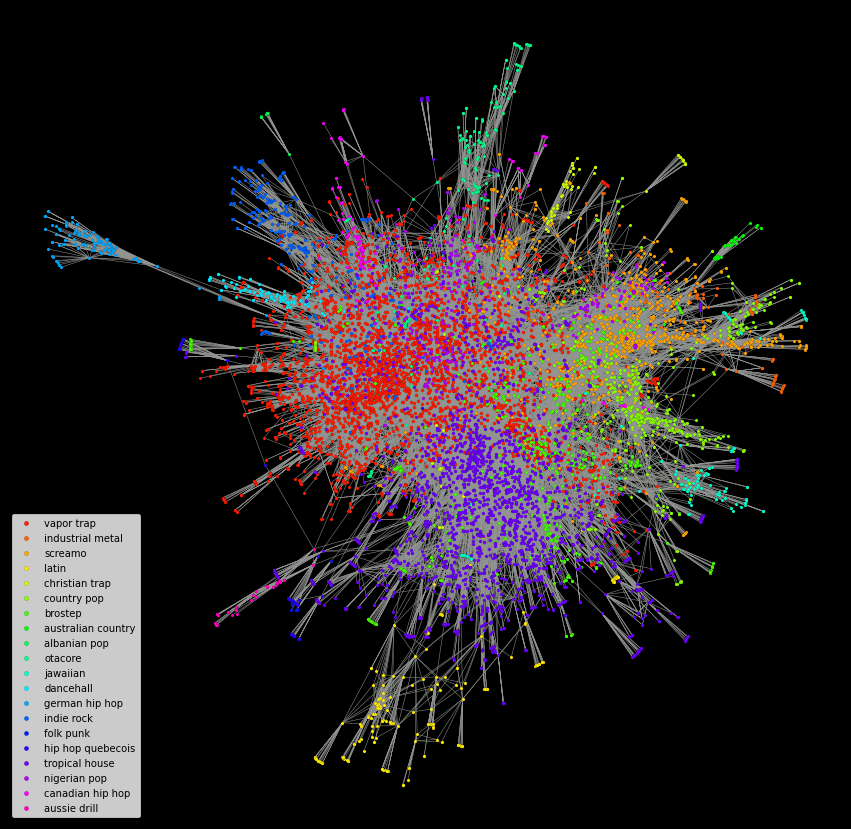

In [130]:
# Draw graph
fig, ax = plt.subplots(figsize=(15,15))
rainbow = plt.cm.get_cmap("gist_rainbow", len(clusters)+1)
color_map = rainbow(range(len(clusters)+1))
pos=nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    nx.draw_networkx_nodes(G, pos=pos, node_size=10, nodelist=cluster, ax=ax, node_color=[color_map[i+1]], 
                           linewidths=0.1, edgecolors='k', label=cluster_labels[i])
nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#929591", width=0.5)
ax.axis("off")
fig.set_facecolor('k')
lgnd = ax.legend(scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([20.0])
plt.show()

In [114]:
# Get clusters via spectral clustering
adj_mat = nx.to_numpy_matrix(G)
sc = SpectralClustering(5, affinity='precomputed', n_init=100, assign_labels='discretize')
%time sc.fit(adj_mat)

CPU times: user 16.1 s, sys: 2.35 s, total: 18.5 s
Wall time: 6.35 s


SpectralClustering(affinity='precomputed', assign_labels='discretize', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=5, n_components=None,
                   n_init=100, n_jobs=None, n_neighbors=10, random_state=None)

In [115]:
# Get clusters by ids
clusters = []
for i in range(5):
    cur_cluster = []
    for j, artist in enumerate(G.nodes):
        if sc.labels_[j] == i:
            cur_cluster.append(artist)
    clusters.append(cur_cluster)

In [116]:
# Compute inverse document frequencies for clusters
idf = defaultdict(int)
for partition in clusters:
    genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
    doc = "#".join(genres).replace(" ", "_").replace("#", " ")
    unique = set()
    for term in doc.split():
        if term not in unique:
            idf[term] += 1
            unique.add(term)
idf = {k:math.log(len(clusters)/v) for k, v in idf.items()}

In [117]:
# Get center of each cluster
labels = {}
cluster_labels = []
for community in clusters:
    sub = G.subgraph(list(community))
    sub_close = nx.betweenness_centrality(sub)
    center = max(sub_close, key=sub_close.get)
    name = get_name(list(community)).replace("_", " ")
    labels[center] = name
    cluster_labels.append(name)
    print(artists_dict[center]["name"], name)

Carrie Underwood country road
Astrid S pop edm
Ledri Vula german hip hop
Gerard Way pop punk
Rich Brian trap


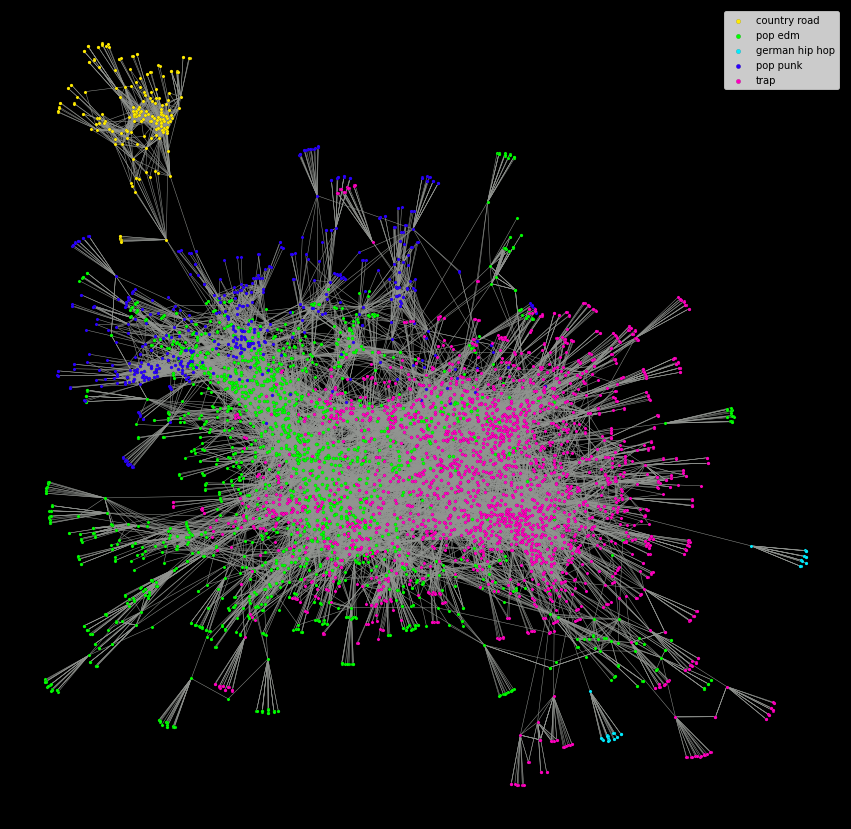

In [118]:
# Draw graph
fig, ax = plt.subplots(figsize=(15,15))
rainbow = plt.cm.get_cmap("gist_rainbow", len(clusters)+1)
color_map = rainbow(range(len(clusters)+1))
#pos=nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    nx.draw_networkx_nodes(G, pos=pos, node_size=10, nodelist=cluster, ax=ax, node_color=[color_map[i+1]], 
                           linewidths=0.1, edgecolors='k', label=cluster_labels[i])
nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#929591", width=0.5)
ax.axis("off")
fig.set_facecolor('k')
lgnd = ax.legend(scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([20.0])
plt.show()

## Centrality Measures

In [50]:
# Compute betweenness centrality
between = nx.betweenness_centrality(G)
close = nx.closeness_centrality(G)
eigen = nx.eigenvector_centrality_numpy(G)

In [51]:
# Compute correlation between centralities and followers
followers = []
between_centrals = []
close_centrals = []
eigen_centrals = []
for artist in between:
    followers.append(artists_dict[artist]["followers"])
    between_centrals.append(between[artist])
    close_centrals.append(close[artist])
    eigen_centrals.append(eigen[artist])

In [52]:
stat, p = shapiro(followers)
print(stat, p)

0.2841746211051941 0.0


In [53]:
# Correlation of betweenness and followers
corr, p = spearmanr(followers, between_centrals)
print(corr, p)

0.43005222467924187 2.0615896505891116e-91


In [54]:
# Correlation of closeness and followers
corr, p = spearmanr(followers, close_centrals)
print(corr, p)

0.3342408215086858 9.836504369045002e-54


In [55]:
# Correlation of closeness and followers
corr, p = spearmanr(followers, eigen_centrals)
print(corr, p)

0.27816156937740705 4.332559404200953e-37


## Bridges

In [56]:
# Get bridges
bridges = nx.bridges(G)